In [1]:
#importing packages & libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
%matplotlib inline
test_images = 'test_images/'
camera_cal_dir = 'camera_cal/'
image_results = 'output_images/'

In [2]:
# 1, Camera distortion calibration with chess board image
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:-1] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = os.listdir(camera_cal_dir)
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
n = 0
for fname in images:
    img = cv2.imread(camera_cal_dir+fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        n += 1
        # print(fname)
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(11,11), (-1,-1),criteria)
        imgpoints.append(corners)
print('Total good calibration images: ', n)
# Calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(mtx.shape)

with open('./camera_dist_param.p', 'wb') as f:
    pickle.dump((mtx, dist), f)
print('Camera Distortion Parameters Saved!')

Total good calibration images:  17
[[  1.15694047e+03   0.00000000e+00   6.65948821e+02]
 [  0.00000000e+00   1.15213880e+03   3.88784788e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
(3, 3)
Camera Distortion Parameters Saved!


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Max: 255 Min: 0
(720, 1280, 3)
[[  230.   700.]
 [  580.   460.]
 [  702.   460.]
 [ 1080.   700.]] [[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
Camera Warped Parameters Saved!


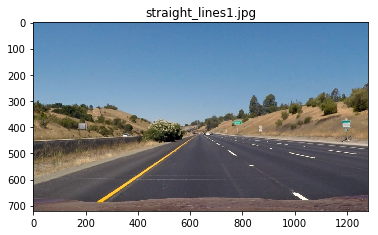

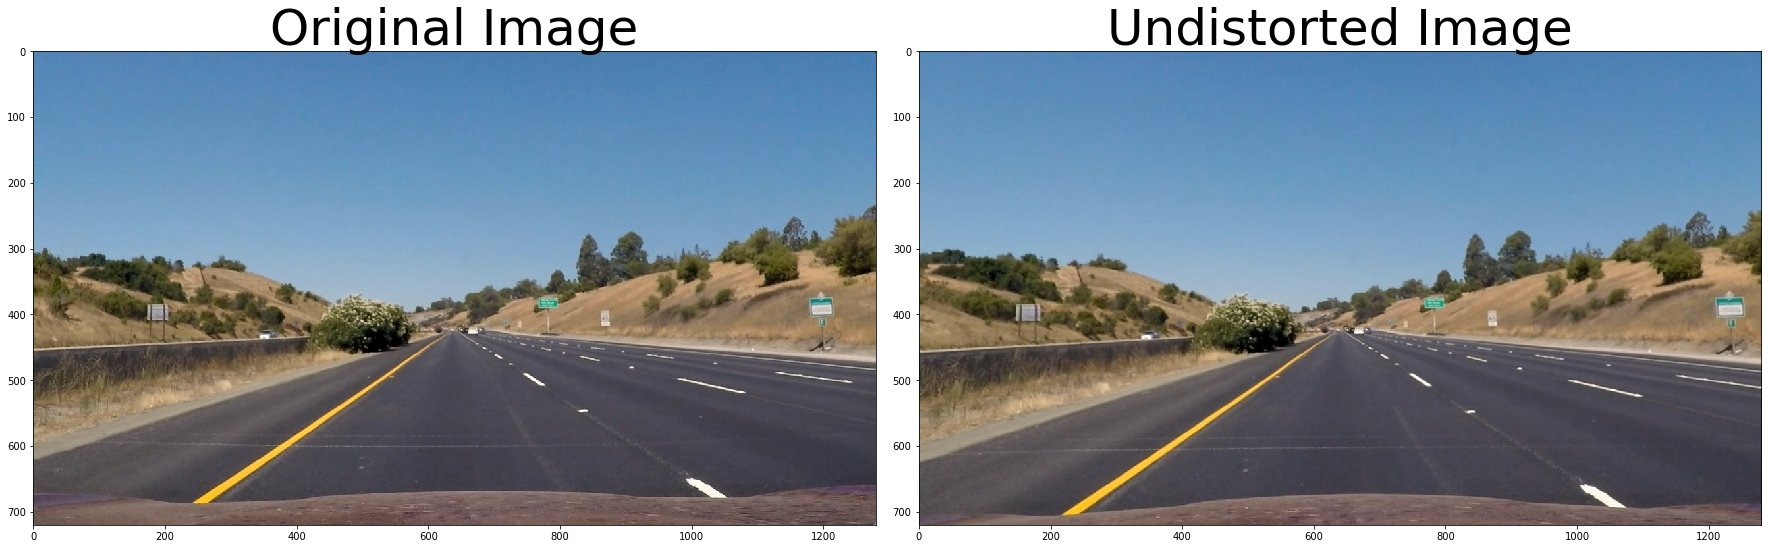

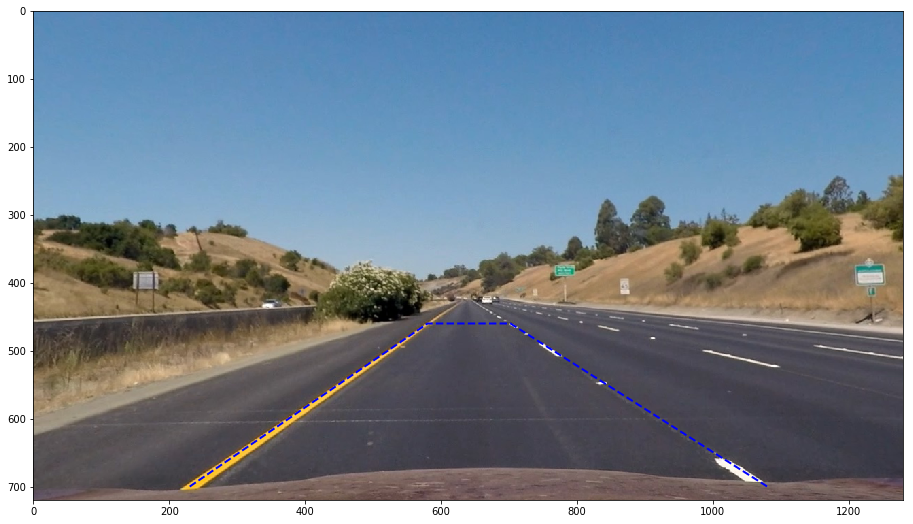

In [5]:
# 3, perspective transform
# 
image_list = os.listdir(test_images)
# print(image_list)
# image_file = image_list[3]
image_file = 'straight_lines1.jpg'
image = mpimg.imread(test_images + image_file)
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Max:', image.max(), 'Min:', image.min())
plt.title(image_file)
plt.imshow(image)
plt.savefig(image_results + 'original_image.png')

image_undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(image_results + 'regular_image_cal.png')

# find the 4 points, image size: 720, 1280
im_xsize = image_undist.shape[1]
im_ysize = image_undist.shape[0]
x_ratio = im_xsize/1280
y_ratio = im_ysize/720
print(image_undist.shape)
vertices = np.array([(np.round(230*x_ratio), np.round(700*x_ratio)), (np.round(580/x_ratio), np.round(460*y_ratio)), \
                      (np.round(702*x_ratio), np.round(460*y_ratio)), (np.round(1080*x_ratio), np.round(700*y_ratio))], dtype=np.int32)
plt.figure(figsize=(24, 9))
plt.imshow(image_undist)
plt.plot(vertices[:, 0], vertices[:, 1], 'b--', lw=2)
plt.savefig(image_results + 'four-points.png')
src = np.float32(vertices)
# dst = np.float32([[275, 680], [275, 450], [1055, 450], [1055, 680]])
x_offset = 290 # offset for dst points
y_offset = 0
# For source points I'm grabbing the outer four detected corners
# src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purpose
dst = np.float32([[x_offset, im_ysize-y_offset], [x_offset, y_offset], [im_xsize-x_offset, y_offset], [im_xsize-x_offset, im_ysize-y_offset]])
print(src, dst)
M = cv2.getPerspectiveTransform(src, dst)
invM = cv2.getPerspectiveTransform(dst, src)
with open('./camera_warp_param.p', 'wb') as f:
    pickle.dump((M, invM), f)
print('Camera Warped Parameters Saved!')
# e) use cv2.warpPerspective() to warp your image to a top-down view
image_top_down = cv2.warpPerspective(image_undist, M, image_undist.shape[1::-1], flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.plot(vertices[:, 0], vertices[:, 1], 'r--', lw=5)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_top_down)
ax2.plot(dst[:, 0], dst[:, 1], 'r--', lw=5)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(image_results + 'undist_warp.png')

In [6]:
# load camera distortion parameters
with open('./camera_dist_param.p', 'rb') as f:
    dist_param = pickle.load(f)
# load perspective warped parameters
with open('./camera_warp_param.p', 'rb') as f:
    warp_param = pickle.load(f)
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = 0
        
        self.frame_cnt = 0
        
        self.all_fit = []
        self.all_fit_cir = []
        self.all_curverad = []
        self.all_offset = []

        self.current_fit = []
        self.current_fit_cir = []
        self.current_curverad = []
        self.current_offset = []
        self.mis_frame = 0
left_lane = Line()
right_lane = Line()

In [7]:
# x or y threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh = (0, 255)):
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output
# magnitude threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
# direction threshold
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(angle_sobel)
    binary_output[(angle_sobel >= thresh[0]) & (angle_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def thresh_pipeline(img, sobel_kernel=3, abs_th=(20, 100), mag_th=(30, 100), dir_th=(0.7, 1.3), s_th=(170, 255), debug = 0):
    
    # Gaussian Blur, to reduce noise
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # convert to GRAY image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sobelx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=sobel_kernel, thresh = abs_th)
    sobely_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=sobel_kernel, thresh = abs_th)
    sobel_mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh = mag_th)
    sobel_dir_binary = dir_thresh(gray, sobel_kernel=sobel_kernel, thresh = dir_th)
    hls_binary = hls_select(img, thresh = s_th)
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(hls_binary == 1) | (((sobelx_binary == 1) & (sobely_binary == 1)) | ((sobel_mag_binary == 1) & (sobel_dir_binary == 1)))] = 1
    # further mask the image with region of interest
    # define region of interest for edge detection
    # Defining vertices for marked area
    im_xsize = combined_binary.shape[1]
    im_ysize = combined_binary.shape[0]
    x_ratio = im_xsize/1280
    y_ratio = im_ysize/720
    vertices = np.array([(np.round(230*x_ratio), np.round(700*x_ratio)), (np.round(580/x_ratio), np.round(460*y_ratio)), \
                          (np.round(702*x_ratio), np.round(460*y_ratio)), (np.round(1080*x_ratio), np.round(700*y_ratio))], dtype=np.int32)
    region_margin = 80
    p0 = (vertices[0][0]-region_margin, vertices[0][1])
    p1 = (vertices[1][0]-np.int(region_margin/3), vertices[1][1])
    p2 = (vertices[2][0]+np.int(region_margin/3), vertices[2][1])
    p3 = (vertices[3][0]+region_margin, vertices[3][1])
    p4 = (vertices[3][0]-region_margin, vertices[3][1])
    p6 = ((vertices[2][0] + vertices[1][0])/2, vertices[2][1] + 0)
    p5 = ((vertices[2][0] + vertices[1][0])/2, vertices[1][1] + 0)
    p7 = (vertices[0][0]+region_margin, vertices[0][1])
    mask_vertices = np.array([(p0, p1, p2, p3, p4, p5, p6, p7)], dtype=np.int32)
    # Masked area
    region_interest_binary = region_of_interest(combined_binary, mask_vertices)
    if debug:
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(24, 32))
        f.tight_layout()
        ax1.imshow(sobelx_binary, cmap='gray')
        ax1.set_title('Sobel x', fontsize=30)
        ax2.imshow(sobely_binary, cmap='gray')
        ax2.set_title('Sobel y', fontsize=30)
        ax3.imshow(sobel_mag_binary, cmap='gray')
        ax3.set_title('Sobel Magnitude', fontsize=30)
        ax4.imshow(sobel_dir_binary, cmap='gray')
        ax4.set_title('Sobel Direction', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        ax5.imshow(hls_binary, cmap='gray')
        ax5.set_title('S', fontsize=30)
        ax6.imshow(combined_binary, cmap='gray')
        ax6.set_title('Combined', fontsize=30)
        ax7.imshow(region_interest_binary, cmap='gray')
        ax7.set_title('Combined with Region of Interest', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('various_sobel_binary.png')
    return region_interest_binary

def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        if 1:
            l_val_max = np.max(conv_signal[l_min_index:l_max_index])
            l_center = np.median(np.argwhere(conv_signal[l_min_index:l_max_index] == l_val_max))+l_min_index-offset
            r_val_max = np.max(conv_signal[r_min_index:r_max_index])
            r_center = np.median(np.argwhere(conv_signal[r_min_index:r_max_index] == r_val_max))+r_min_index-offset
        else:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids
 
# find the lanelines
def find_lanelines(binary_warped, mode = 0, left_fit_curr = [], right_fit_curr = [], detector = 'sliding_window', debug = 0):
    # Set the width of the windows +/- margin
    margin = 100
    if mode == 0: # laneline detect mode
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        if detector == 'histogram':
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set minimum number of pixels found to recenter window
            minpix = 50
        if detector == 'sliding_window':
            window_width = 100 
            window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
            # print(window_centroids)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            if detector == 'histogram':
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
            if detector == 'sliding_window':
                win_xleft_low = np.int(window_centroids[window][0] - margin)
                win_xleft_high = np.int(window_centroids[window][0] + margin)
                win_xright_low = np.int(window_centroids[window][1] - margin)
                win_xright_high = np.int(window_centroids[window][1] + margin)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if detector == 'histogram':
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            
    else: # laneline track mode
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit_curr[0]*(nonzeroy**2) + left_fit_curr[1]*nonzeroy + left_fit_curr[2] - margin)) & (nonzerox < (left_fit_curr[0]*(nonzeroy**2) + left_fit_curr[1]*nonzeroy + left_fit_curr[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit_curr[0]*(nonzeroy**2) + right_fit_curr[1]*nonzeroy + right_fit_curr[2] - margin)) & (nonzerox < (right_fit_curr[0]*(nonzeroy**2) + right_fit_curr[1]*nonzeroy + right_fit_curr[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if 0: # combine left and right lane
        lane_width = 700 # in pixel
        leftx = np.append(leftx, rightx - lane_width)
        lefty = np.append(lefty, righty)
        rightx = np.append(rightx, leftx + lane_width)
        righty = np.append(righty, lefty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit a second order polynomial to each
    lane_fit_update(left_lane, leftx, lefty, y_eval = binary_warped.shape[0])
    lane_fit_update(right_lane, rightx, righty, y_eval = binary_warped.shape[0])
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    left_fit_cr = left_lane.current_fit_cir
    right_fit_cr = right_lane.current_fit_cir
    
    left_curverad = left_lane.current_curverad
    right_curverad = right_lane.current_curverad
    
    left_edge = left_lane.current_offset
    right_edge = right_lane.current_offset
    # curvature calculation
    # Fit new polynomials to x,y in world space
    # left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    # right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # print(left_fit_cr, right_fit_cr)
    # y_eval = np.int(binary_warped.shape[0]/2)
    # y_eval = binary_warped.shape[0]
    #  left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    # right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # offset to center
    # left_edge = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    # right_edge = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    
    offset_to_center = binary_warped.shape[1]/2 * xm_per_pix - (left_edge + right_edge)/2
    
    if debug:# virtualization
        print(left_curverad, 'm', right_curverad, 'm')
        print('offset to center = ', offset_to_center, 'm')
        if mode == 0:
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.figure(figsize = (12, 8))
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.title('Laneline Detecting', fontsize=30)
            plt.savefig('lane_find_1.png')
        else:
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            plt.figure(figsize = (12, 8))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.title('Laneline Tracking', fontsize=30)
            plt.savefig('lane_find_2.png')
    return left_fit, right_fit, (left_curverad, right_curverad), offset_to_center

def lane_fit_update(lane_line, lane_x, lane_y, ym_per_pix = 30/720, xm_per_pix = 3.7/700, y_eval = 720):

    min_pixels = 10
    
    lane_line.frame_cnt += 1
    if len(lane_x) > min_pixels: # must has enough pixles
        lane_fit = np.polyfit(lane_y, lane_x, 2)
        lane_fit_cir = np.polyfit(lane_y*ym_per_pix, lane_x*xm_per_pix, 2)
        # Now our radius of curvature is in meters
        lane_curverad = ((1 + (2*lane_fit_cir[0]*y_eval*ym_per_pix + lane_fit_cir[1])**2)**1.5) / np.absolute(2*lane_fit_cir[0])
        # offset at bottom
        lane_offset = lane_fit_cir[0]*(y_eval*ym_per_pix)**2 + lane_fit_cir[1]*(y_eval*ym_per_pix) + lane_fit_cir[2]
        # for debug
        lane_line.all_fit.append(lane_fit)
        lane_line.all_fit_cir.append(lane_fit_cir)
        lane_line.all_curverad.append(lane_curverad)
        lane_line.all_offset.append(lane_offset)
        if lane_line.detected == 0:
            lane_line.current_fit = lane_fit
            lane_line.current_fit_cir = lane_fit_cir
            lane_line.current_curverad = lane_curverad
            lane_line.current_offset = lane_offset
            
            lane_line.detected = 1
            lane_line.mis_frame = 0
        else:
            # 1. fitting coefficients change
            # 2. radius is too small
            # 3. left_x or right_x change too much
            if (np.abs(lane_fit[0] - lane_line.current_fit[0]) <= 0.005) & (np.abs(lane_curverad) > 300) & (np.abs(lane_offset - lane_line.current_offset) < 50*xm_per_pix): # difference from current_fit must be small
            # update fitting information
                alpha = 0.9 #  alpha filtering
                lane_line.current_fit = lane_line.current_fit * alpha + (1-alpha) * lane_fit
                lane_line.current_fit_cir = lane_line.current_fit_cir * alpha + (1-alpha) * lane_fit_cir
                lane_line.current_curverad = lane_line.current_curverad * alpha + (1-alpha) * lane_curverad
                lane_line.current_offset = lane_line.current_offset * alpha + (1-alpha) * lane_offset
                
                lane_line.detected = 1
                lane_line.mis_frame = 0
            else: # no update, increase mis_frame by 1
                lane_line.mis_frame += 1
                print('Fitting failed @ Frame: ', lane_line.frame_cnt)
    else: # no update, increase mis_frame by 1
        lane_line.mis_frame += 1
        print('NOT enough pixels @ Frame: ', lane_line.frame_cnt)
    if lane_line.mis_frame >= 5: # detection failed
        lane_line.detected == 0
        print('Detection Failed @ Frame: ', lane_line.frame_cnt)
    
    # return new_lane = lane_line
    
# def process_image(image, dist_param, warp_param, dbg = 0):
def process_image(image, dbg = 0):
    # image_results = './' # image saving directory
    # step 1: undistort the image
    mtx = dist_param[0]
    dist = dist_param[1]
    image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    if dbg == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(image_undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('regular_image_cal.png')
    # step 2: detect edge with gradient and s-channel threshold
    sobel_kernel = 7
    abs_th = (20, 255)
    mag_th = (30, 255)
    dir_th = (0.6, 1.1)
    s_th = (160, 255)
    image_thresh = thresh_pipeline(image_undist, sobel_kernel=sobel_kernel, abs_th=abs_th, mag_th=mag_th, dir_th=dir_th, s_th=s_th, debug = dbg)
    # step 3: perspective transform
    M = warp_param[0]
    invM = warp_param[1]
    image_warped = cv2.warpPerspective(image_thresh, M, image_thresh.shape[1::-1], flags=cv2.INTER_LINEAR)
    if dbg == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image_thresh, cmap='gray')
        # ax1.plot(vertices[:, 0], vertices[:, 1], 'r--', lw=5)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(image_warped, cmap='gray')
        # ax2.plot(dst[:, 0], dst[:, 1], 'r--', lw=5)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        ax2.set_xlim(0, 1280)
        ax2.set_ylim(720, 0)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('perspective.png')
    # step 4: find lanelines with sliding windows, and calculate curverature and offset from center
    if (left_lane.detected == 1) & (right_lane.detected == 1):
        [left_fit, right_fit, curverad, offset_to_center] = find_lanelines(image_warped, mode = 1, left_fit_curr = left_lane.current_fit, right_fit_curr = right_lane.current_fit, detector = 'histogram', debug = dbg)
    else: 
        [left_fit, right_fit, curverad, offset_to_center] = find_lanelines(image_warped, mode = 0, detector = 'histogram', debug = dbg)
    
    # step 5: revert the lanelines back to original image (undistorted)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, image_warped.shape[0]-1, image_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invM, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_undist_lanemark= cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    # put text on image
    cv2.putText(image_undist_lanemark, text='Curveture Radius: '+str(round(np.mean(curverad), 2))+' Meters', org=(500,50),fontFace=3, fontScale=1, color=(0,0,0), thickness=2)
    cv2.putText(image_undist_lanemark, text='Offset to Center: '+str(round(offset_to_center, 2))+' Meters', org=(500,100),fontFace=3, fontScale=1, color=(0,0,0), thickness=2)

    if dbg == 1:
        plt.figure(figsize = (12, 8))
        plt.imshow(image_undist_lanemark)
        plt.savefig('lane_line_add.png')
        # plt.text(800, 50, 'Curveture Radius: '+str(round(np.mean(curverad), 2))+' Meters', fontsize = 12)
        # plt.text(800, 100, 'Offset to Center: '+str(round(offset_to_center, 2))+' Meters', fontsize = 12)

    
    return image_undist_lanemark

In [8]:
# vedio test bench
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# clip1 = VideoFileClip("harder_challenge_video.mp4")
# white_output = 'wharder_challenge_video.mp4'
# clip1 = VideoFileClip("challenge_video.mp4")
# white_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_output = 'project_video_output.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# white_clip = clip1.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))

In [9]:
%time white_clip.write_videofile(white_output, audio=False)
# play video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  1%|          | 8/1261 [00:02<07:20,  2.84it/s]

Fitting failed @ Frame:  9


  1%|          | 9/1261 [00:03<07:15,  2.87it/s]

Fitting failed @ Frame:  10


  3%|▎         | 34/1261 [00:11<06:44,  3.03it/s]

Fitting failed @ Frame:  35


 13%|█▎        | 159/1261 [00:54<06:15,  2.93it/s]

Fitting failed @ Frame:  160


 14%|█▍        | 176/1261 [01:00<06:19,  2.86it/s]

Fitting failed @ Frame:  177


 14%|█▍        | 177/1261 [01:00<06:18,  2.86it/s]

Fitting failed @ Frame:  178


 14%|█▍        | 178/1261 [01:01<06:23,  2.82it/s]

Fitting failed @ Frame:  179


 21%|██▏       | 270/1261 [01:33<05:38,  2.93it/s]

Fitting failed @ Frame:  271


 24%|██▍       | 305/1261 [01:45<05:32,  2.88it/s]

Fitting failed @ Frame:  306


 24%|██▍       | 306/1261 [01:45<05:45,  2.76it/s]

Fitting failed @ Frame:  307


 26%|██▌       | 329/1261 [01:54<05:47,  2.68it/s]

Fitting failed @ Frame:  330


 43%|████▎     | 543/1261 [03:13<04:25,  2.70it/s]

Fitting failed @ Frame:  544


 43%|████▎     | 544/1261 [03:13<04:24,  2.71it/s]

Fitting failed @ Frame:  545


 43%|████▎     | 546/1261 [03:14<04:42,  2.53it/s]

Fitting failed @ Frame:  547


 43%|████▎     | 547/1261 [03:14<04:32,  2.62it/s]

Fitting failed @ Frame:  548


 43%|████▎     | 548/1261 [03:15<04:25,  2.68it/s]

Fitting failed @ Frame:  549


 44%|████▎     | 550/1261 [03:15<04:14,  2.79it/s]

Fitting failed @ Frame:  551


 46%|████▌     | 583/1261 [03:26<03:37,  3.12it/s]

Fitting failed @ Frame:  584


 46%|████▋     | 584/1261 [03:27<03:35,  3.14it/s]

Fitting failed @ Frame:  585


 46%|████▋     | 585/1261 [03:27<03:31,  3.20it/s]

Fitting failed @ Frame:  586


 46%|████▋     | 586/1261 [03:27<03:30,  3.21it/s]

Fitting failed @ Frame:  587


 47%|████▋     | 587/1261 [03:28<03:28,  3.23it/s]

Fitting failed @ Frame:  588
Detection Failed @ Frame:  588


 77%|███████▋  | 977/1261 [05:44<01:37,  2.91it/s]

Fitting failed @ Frame:  978


 78%|███████▊  | 978/1261 [05:44<01:36,  2.93it/s]

Fitting failed @ Frame:  979


 78%|███████▊  | 979/1261 [05:45<01:36,  2.91it/s]

Fitting failed @ Frame:  980


 78%|███████▊  | 980/1261 [05:45<01:37,  2.88it/s]

Fitting failed @ Frame:  981


 78%|███████▊  | 981/1261 [05:45<01:37,  2.87it/s]

Fitting failed @ Frame:  982
Detection Failed @ Frame:  982


 78%|███████▊  | 982/1261 [05:46<01:37,  2.87it/s]

Fitting failed @ Frame:  983
Detection Failed @ Frame:  983


 78%|███████▊  | 984/1261 [05:47<01:49,  2.54it/s]

Fitting failed @ Frame:  985


 78%|███████▊  | 985/1261 [05:47<01:45,  2.61it/s]

Fitting failed @ Frame:  986


 78%|███████▊  | 987/1261 [05:48<01:39,  2.76it/s]

Fitting failed @ Frame:  988


 78%|███████▊  | 989/1261 [05:48<01:33,  2.90it/s]

Fitting failed @ Frame:  990


 79%|███████▉  | 994/1261 [05:50<01:30,  2.96it/s]

Fitting failed @ Frame:  995


 79%|███████▉  | 1001/1261 [05:52<01:27,  2.98it/s]

Fitting failed @ Frame:  1002


 80%|███████▉  | 1004/1261 [05:53<01:24,  3.03it/s]

Fitting failed @ Frame:  1005


 80%|████████  | 1011/1261 [05:56<01:28,  2.81it/s]

Fitting failed @ Frame:  1012


 82%|████████▏ | 1037/1261 [06:05<01:18,  2.85it/s]

Fitting failed @ Frame:  1038


 82%|████████▏ | 1038/1261 [06:05<01:19,  2.81it/s]

Fitting failed @ Frame:  1039


 82%|████████▏ | 1039/1261 [06:05<01:19,  2.79it/s]

Fitting failed @ Frame:  1040


 82%|████████▏ | 1040/1261 [06:06<01:19,  2.78it/s]

Fitting failed @ Frame:  1041


 83%|████████▎ | 1041/1261 [06:06<01:20,  2.73it/s]

Fitting failed @ Frame:  1042
Detection Failed @ Frame:  1042


 83%|████████▎ | 1043/1261 [06:07<01:19,  2.74it/s]

Fitting failed @ Frame:  1044


 83%|████████▎ | 1045/1261 [06:08<01:20,  2.67it/s]

Fitting failed @ Frame:  1046


100%|█████████▉| 1260/1261 [07:22<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 41s, sys: 1min 38s, total: 8min 19s
Wall time: 7min 23s


(1261, 3) (1261, 3)


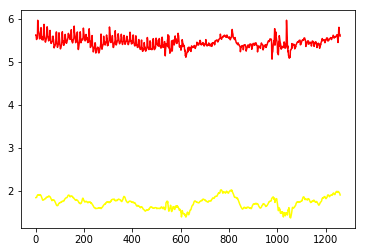

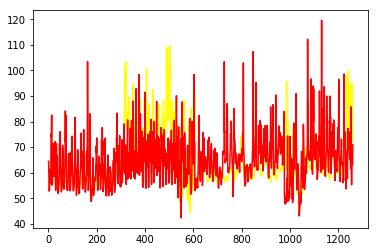

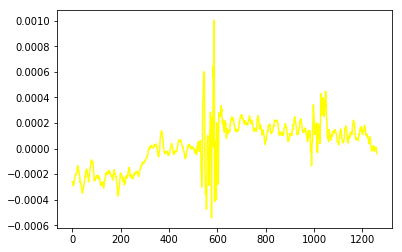

In [10]:
plt.figure()
print(np.shape(left_lane.all_fit), np.shape(right_lane.all_fit))

plt.plot(left_lane.all_offset, color='yellow')
plt.plot(right_lane.all_offset, color='red')

plt.figure()

plt.plot(20*np.log10(left_lane.all_curverad), color='yellow')
plt.plot(20*np.log10(right_lane.all_curverad), color='red')

plt.figure()

coeff2 = []
coeff1 = []
coeff0 = []
for item in left_lane.all_fit:
    coeff2.append(item[0])
    coeff1.append(item[1])
    coeff0.append(item[2])

plt.figure()

plt.plot(coeff2, color='yellow')

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Max: 255 Min: 0
Fitting failed @ Frame:  1262
Fitting failed @ Frame:  1262
23362.702485 m 3303.47515876 m
offset to center =  -0.397414143462 m


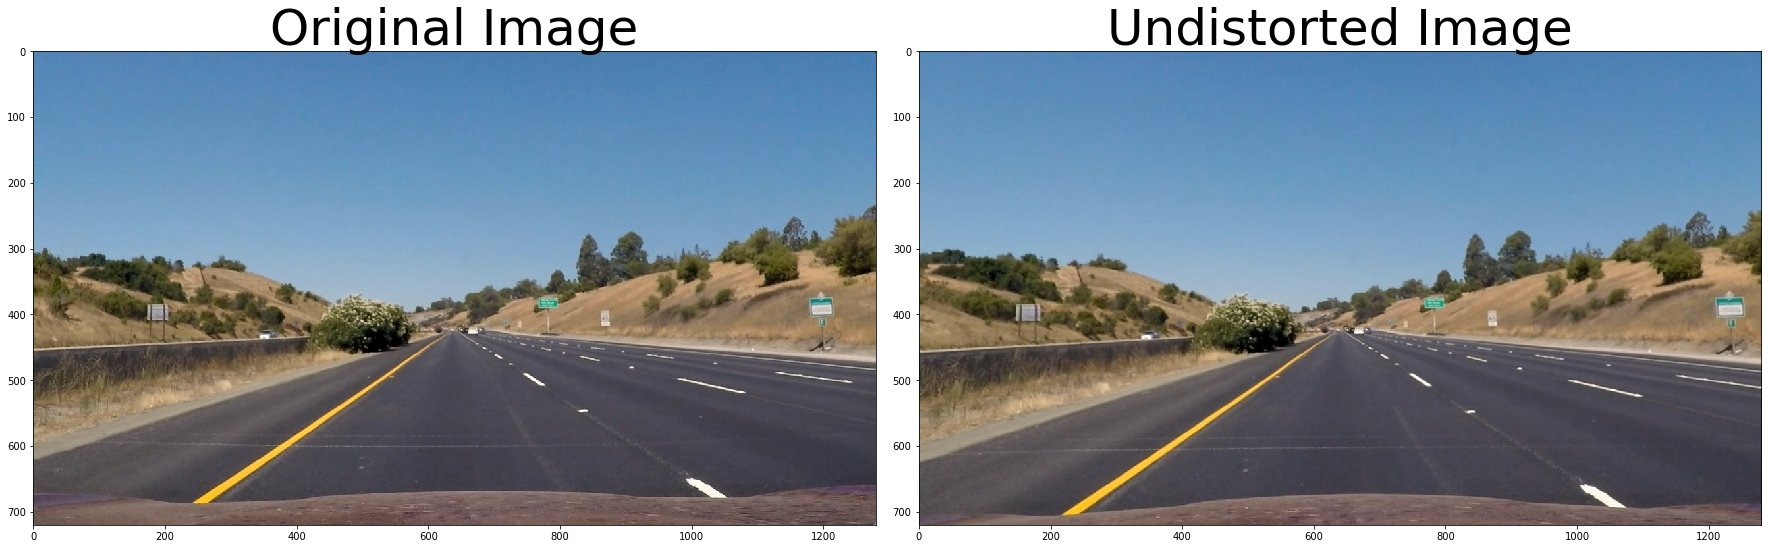

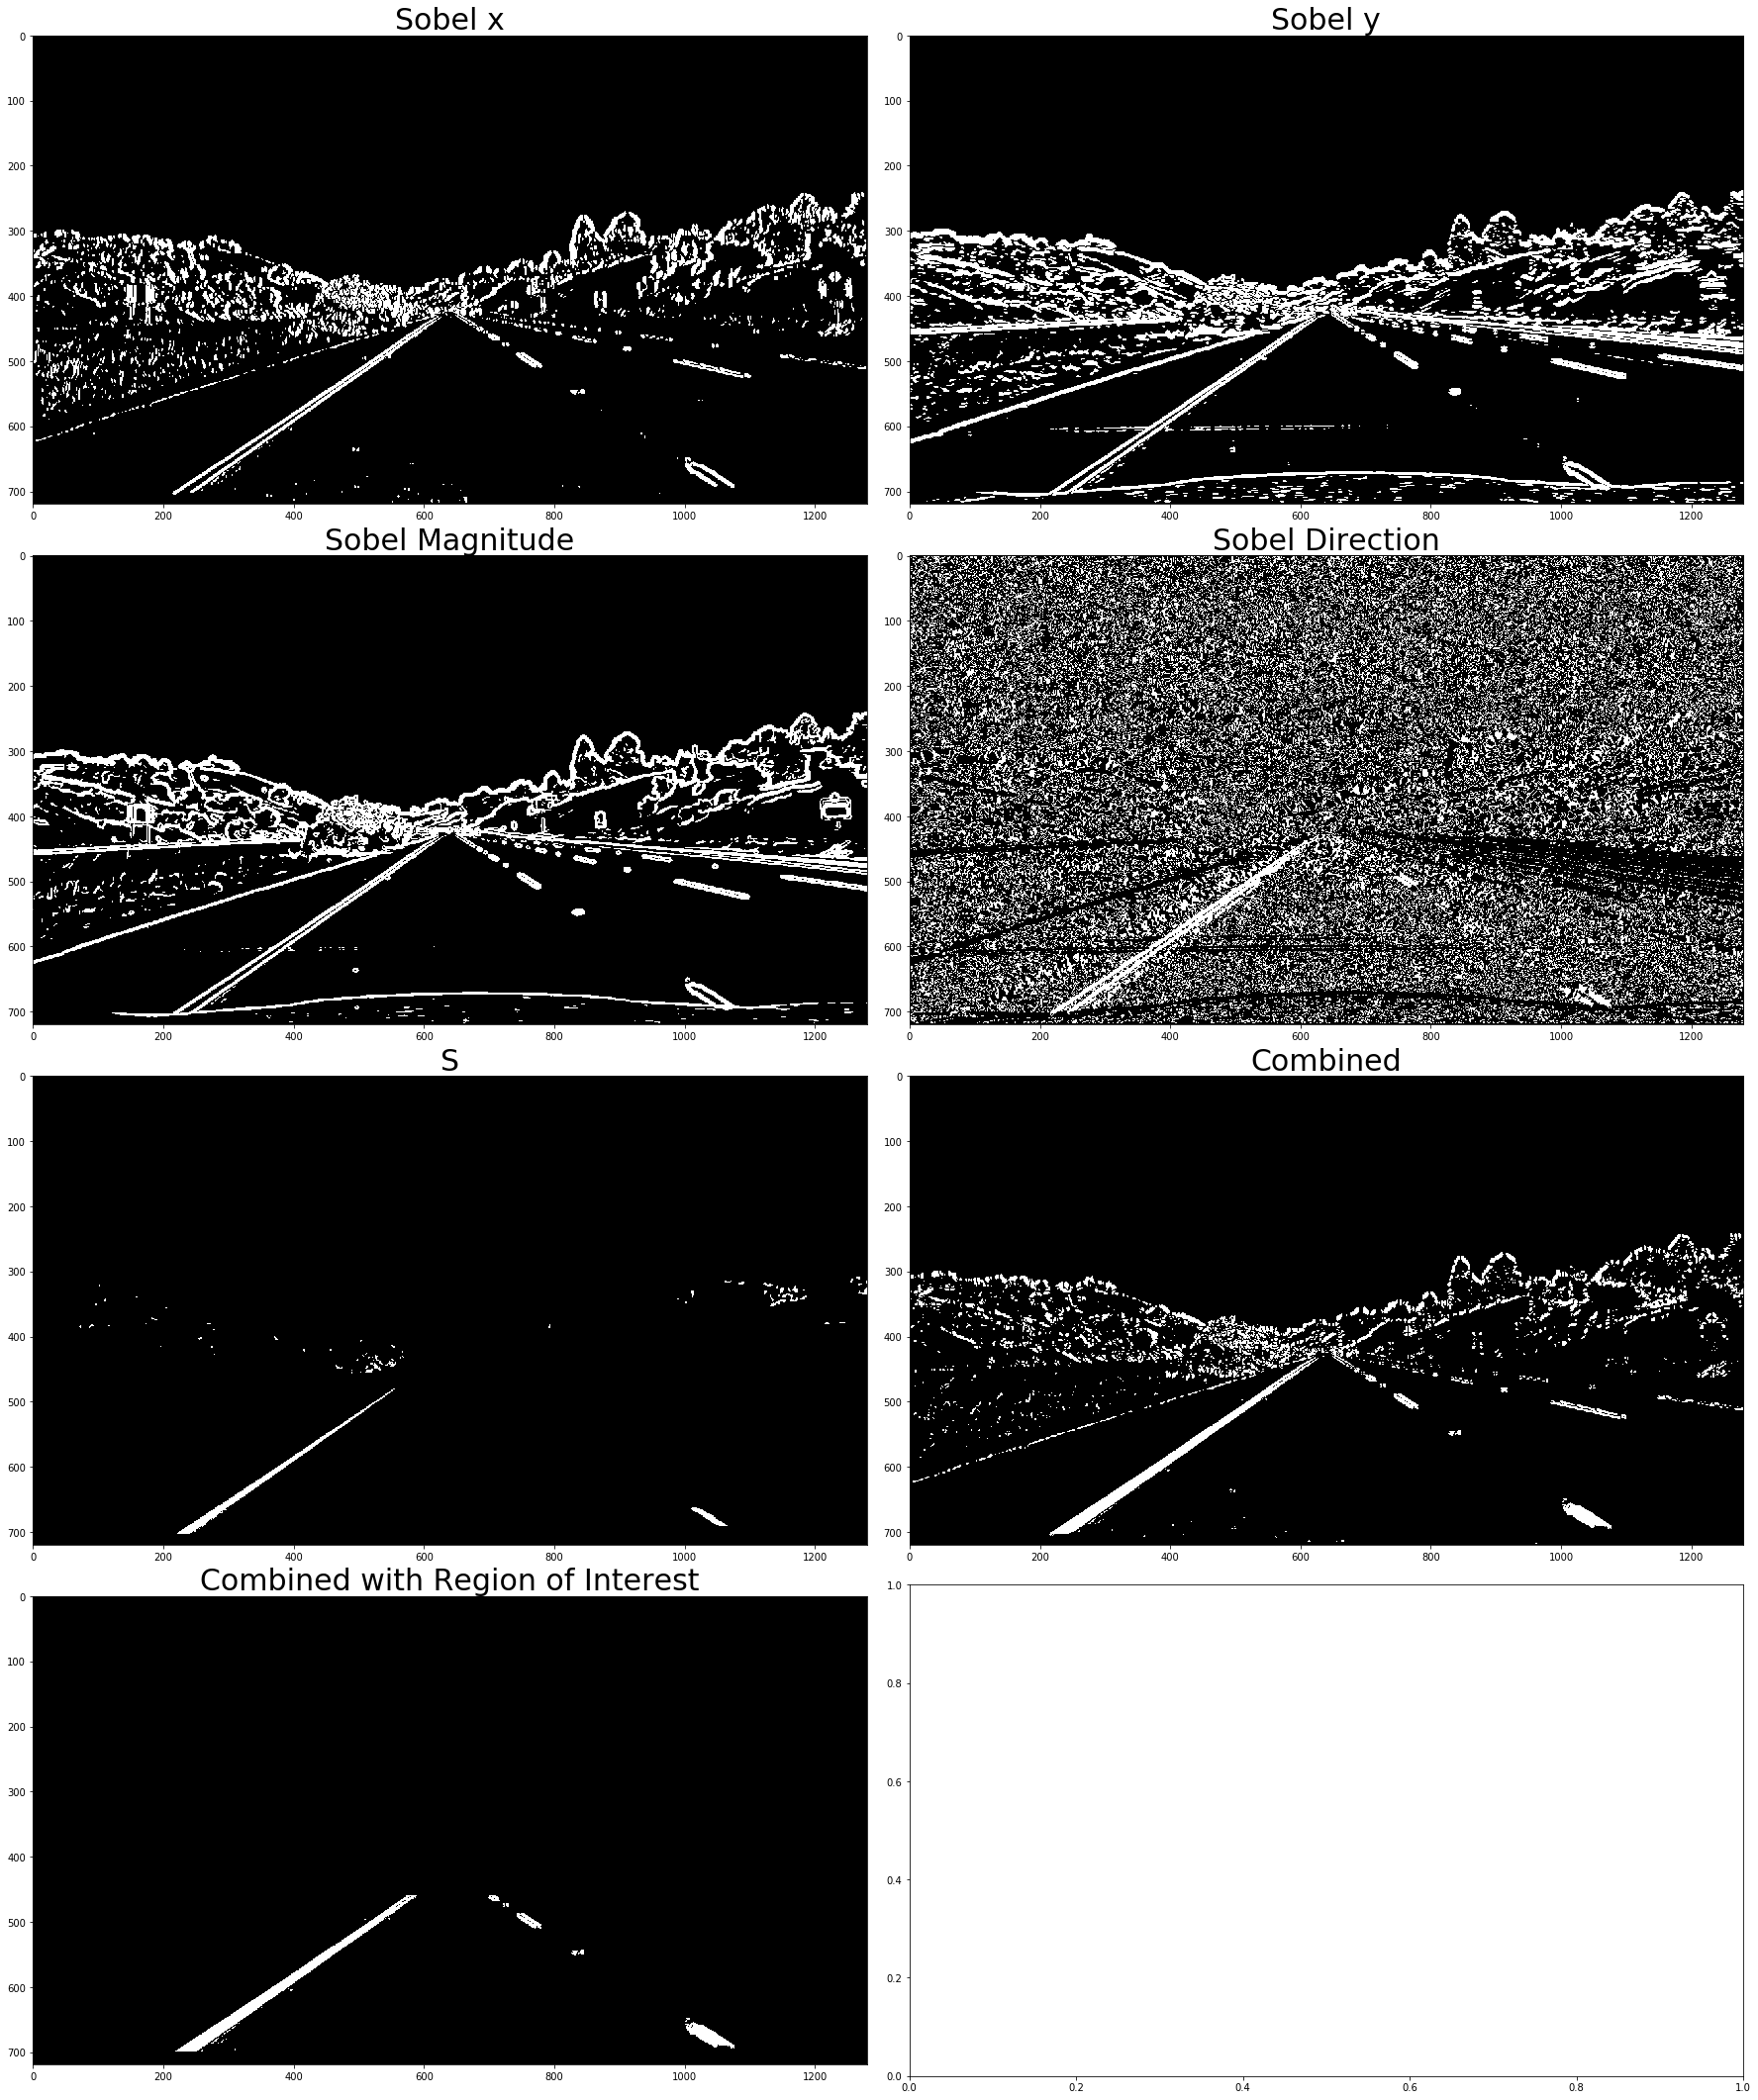

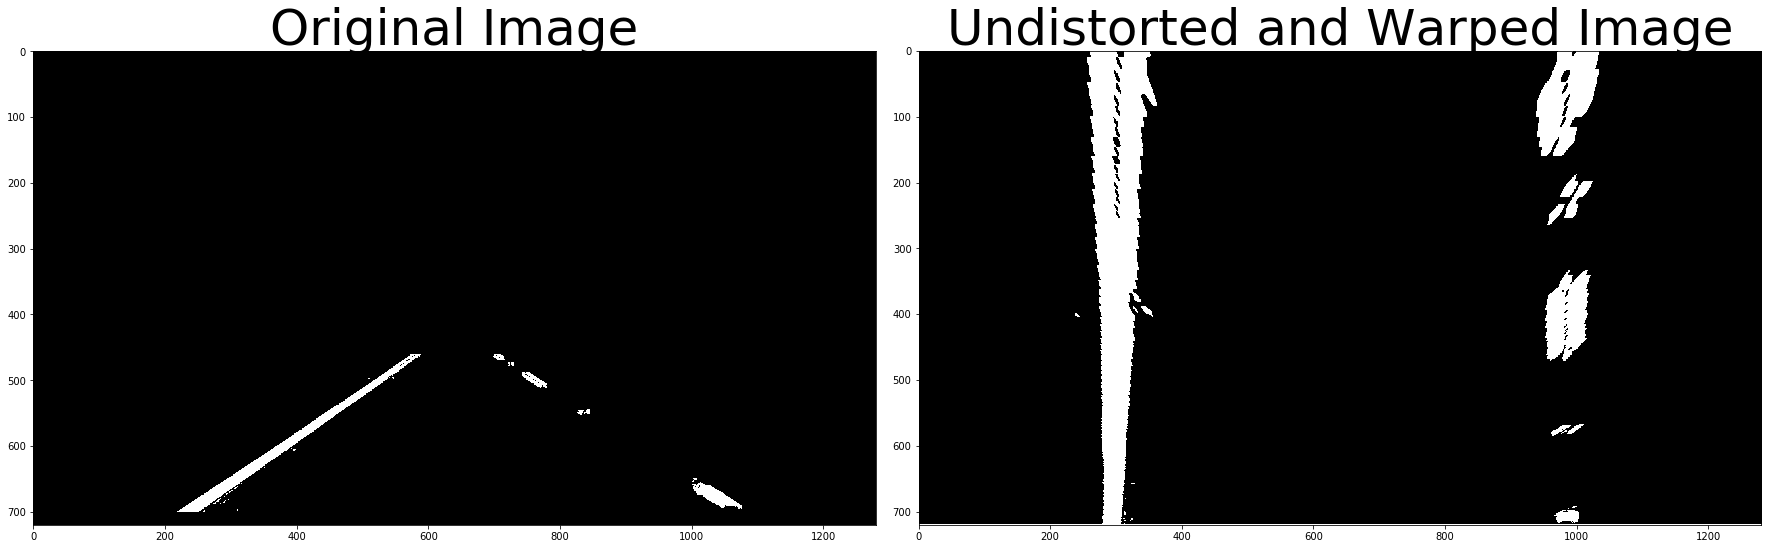

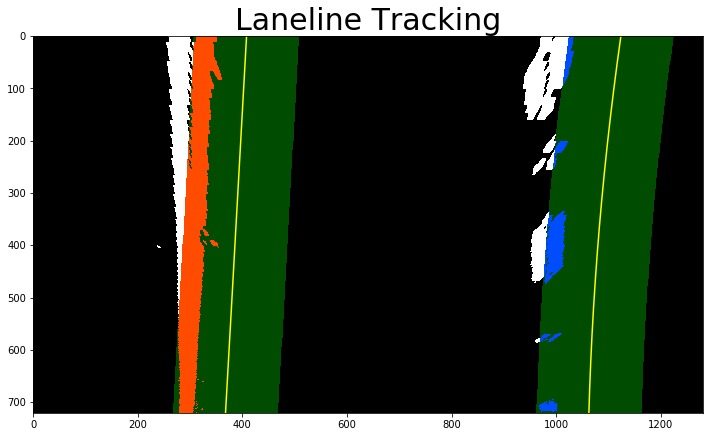

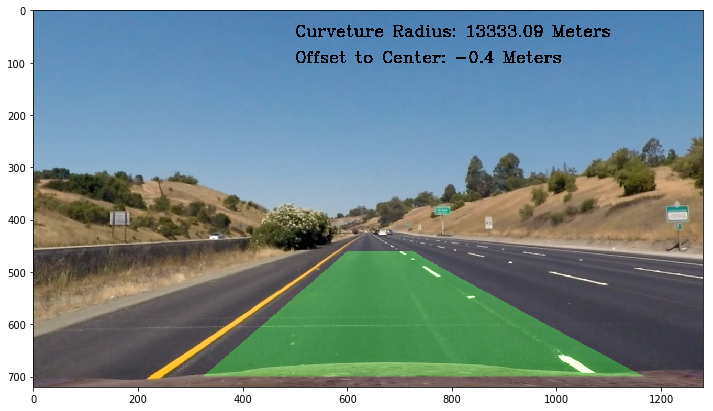

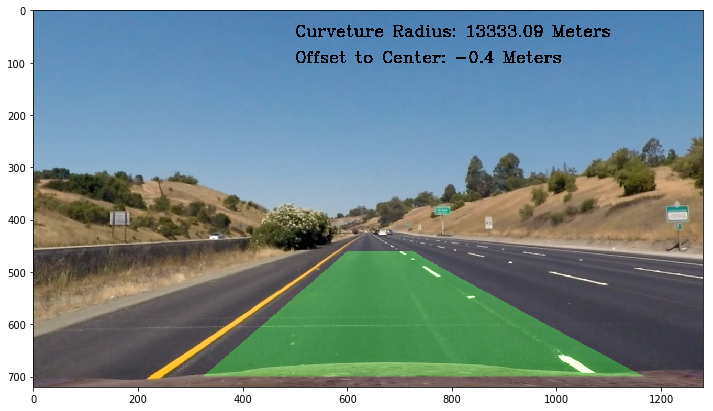

In [11]:
# left_lane = Line()
# right_lane = Line()
# single image test bench
image_list = os.listdir(test_images)
# print(image_list)
# image_file = image_list[4]
image_file = 'straight_lines1.jpg'
image = mpimg.imread(test_images + image_file)
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Max:', image.max(), 'Min:', image.min())
lanemark_image = process_image(image, dbg = 1)
# plt.figure()
plt.figure(figsize = (12, 8))
plt.imshow(lanemark_image)